### Import packages and libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight

import os
import warnings
warnings.filterwarnings('ignore')

  ### Definition of filenames


In [ ]:
#labeled set
labels_file = './labeled_set_lc_classifier_SanchezSaez_2020.csv'

#features
features_file = './features_for_lc_classifier_20200609.csv'


### reading the training set files

In [ ]:
df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarding infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['classALeRCE'].values.size)
print(df_feat.head())

123496
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [ ]:
#defining taxonomy tree
df_labels['class_original'] = df_labels['classALeRCE']

#defining the classes

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(123496,)


,class_original,class_hierachical
oid,,
ZTF19aapcxhy,AGN,Stochastic
ZTF18abtmwvo,AGN,Stochastic
ZTF18acvgdfy,AGN,Stochastic
ZTF19aabvjsi,AGN,Stochastic
ZTF18aadyxlg,AGN,Stochastic


In [ ]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',
'iqr_1',
'iqr_2',
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')


df = df.replace([np.inf, -np.inf], np.nan)

df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

df.head()

123496


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aapcxhy,0.068704,0.052665,0.665183,0.501831,1.0,1.0,0.250000,0.307692,0.0,0.0,...,0.780000,0.013542,0.796,2.889,8.106832,5.217832,8.668390,5.779390,0.202128,1.155121
ZTF18abtmwvo,0.115177,-999.000000,0.996398,-999.000000,1.0,-999.0,0.428571,-999.000000,0.0,-999.0,...,0.717857,0.216488,0.807,2.964,-999.000000,-999.000000,9.126021,6.162021,0.081005,-999.000000
ZTF18acvgdfy,0.050608,-999.000000,0.353987,-999.000000,1.0,-999.0,0.500000,-999.000000,0.0,-999.0,...,0.683333,0.088542,0.606,2.876,-999.000000,-999.000000,8.483215,5.607215,0.023222,-999.000000
ZTF19aabvjsi,-999.000000,0.028547,-999.000000,0.494246,-999.0,1.0,-999.000000,0.333333,-999.0,0.0,...,0.683333,0.035875,0.938,3.017,8.099364,5.082364,-999.000000,-999.000000,-999.000000,0.529107
ZTF18aadyxlg,-999.000000,0.021935,-999.000000,0.543918,-999.0,1.0,-999.000000,0.500000,-999.0,0.0,...,0.683333,0.161542,0.959,3.021,8.041334,5.020334,-999.000000,-999.000000,-999.000000,0.277404


In [ ]:
#which are the features included in the model?
print(np.array(df.columns))
print(len(np.array(df.columns)))

['Amplitude_1' 'Amplitude_2' 'AndersonDarling_1' 'AndersonDarling_2'
 'Autocor_length_1' 'Autocor_length_2' 'Beyond1Std_1' 'Beyond1Std_2'
 'Con_1' 'Con_2' 'Eta_e_1' 'Eta_e_2' 'ExcessVar_1' 'ExcessVar_2'
 'GP_DRW_sigma_1' 'GP_DRW_sigma_2' 'GP_DRW_tau_1' 'GP_DRW_tau_2' 'Gskew_1'
 'Gskew_2' 'Harmonics_mag_1_1' 'Harmonics_mag_1_2' 'Harmonics_mag_2_1'
 'Harmonics_mag_2_2' 'Harmonics_mag_3_1' 'Harmonics_mag_3_2'
 'Harmonics_mag_4_1' 'Harmonics_mag_4_2' 'Harmonics_mag_5_1'
 'Harmonics_mag_5_2' 'Harmonics_mag_6_1' 'Harmonics_mag_6_2'
 'Harmonics_mag_7_1' 'Harmonics_mag_7_2' 'Harmonics_mse_1'
 'Harmonics_mse_2' 'Harmonics_phase_2_1' 'Harmonics_phase_2_2'
 'Harmonics_phase_3_1' 'Harmonics_phase_3_2' 'Harmonics_phase_4_1'
 'Harmonics_phase_4_2' 'Harmonics_phase_5_1' 'Harmonics_phase_5_2'
 'Harmonics_phase_6_1' 'Harmonics_phase_6_2' 'Harmonics_phase_7_1'
 'Harmonics_phase_7_2' 'IAR_phi_1' 'IAR_phi_2' 'LinearTrend_1'
 'LinearTrend_2' 'MHPS_high_1' 'MHPS_high_2' 'MHPS_low_1' 'MHPS_low_2'
 'MHPS_rati

In [ ]:
#how many sources belong to each class?
for idx, cl in enumerate(label_order):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1272
SNIbc 94
SNII 328
SLSN 24
QSO 26168
AGN 4667
Blazar 1267
YSO 1740
CV/Nova 871
LPV 14076
E 37901
DSCT 732
RRL 32482
CEP 618
Periodic-Other 1256


Counter({'E': 37901, 'RRL': 32482, 'QSO': 26168, 'LPV': 14076, 'AGN': 4667, 'YSO': 1740, 'SNIa': 1272, 'Blazar': 1267, 'Periodic-Other': 1256, 'CV/Nova': 871, 'DSCT': 732, 'CEP': 618, 'SNII': 328, 'SNIbc': 94, 'SLSN': 24})
                number
E                37901
RRL              32482
QSO              26168
LPV              14076
AGN               4667
YSO               1740
SNIa              1272
Blazar            1267
Periodic-Other    1256
CV/Nova            871
DSCT               732
CEP                618
SNII               328
SNIbc               94
SLSN                24


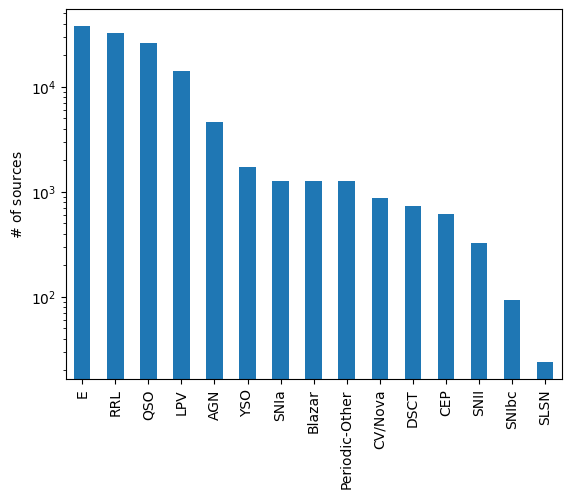

In [ ]:
#plotting the number of sources per class for the labeled set
class_counts = Counter(labels['class_original'])
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)


plt.yscale('log')

plt.ylabel(r'$\#$ of sources')

plt.savefig('number_sources_labeled_set.pdf',bbox_inches='tight')

  ### Defining functions to plot the confusion matrix and the feature importance

In [ ]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()



def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### Pre-processing training data

In [ ]:
Y_hierarchical = labels['class_hierachical']
Y_original = labels['class_original']

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
          Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

X_test_periodic = X_test_hierarchical
X_test_stochastic = X_test_hierarchical
X_test_transient = X_test_hierarchical

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

123496
123496
69651 27771 1374


In [ ]:
print(X_train_hierarchical.index)
print(X_test_hierarchical.index)

os.system('mkdir final_BHRF_model')

np.save('final_BHRF_model/labels_training_sample', X_train_hierarchical.index.values)
np.save('final_BHRF_model/labels_testint_sample', X_test_hierarchical.index.values)

Index(['ZTF18abrwutn', 'ZTF19aanjxib', 'ZTF19aavouyj', 'ZTF19aamojyh',
       'ZTF18aabfrko', 'ZTF19aadoqeo', 'ZTF18abcpqvf', 'ZTF18aaadlma',
       'ZTF19aamkefd', 'ZTF18abilowj',
       ...
       'ZTF19abotpmw', 'ZTF18ablrlye', 'ZTF18abtgnlx', 'ZTF18aaadsyu',
       'ZTF18aayklhy', 'ZTF18abjdxjw', 'ZTF18aakxxvr', 'ZTF18acyxsfs',
       'ZTF18acbypiq', 'ZTF18actwxvp'],
      dtype='object', name='oid', length=98796)
Index(['ZTF18abhdxit', 'ZTF18aakyjxu', 'ZTF19aaapqhv', 'ZTF19aabvkdc',
       'ZTF18abtilfy', 'ZTF18abcpwoe', 'ZTF19aasbpnf', 'ZTF18aanffox',
       'ZTF18absqkmx', 'ZTF18abtmfqh',
       ...
       'ZTF17aacnwvf', 'ZTF18abcdodj', 'ZTF17aaajlcg', 'ZTF18abknxab',
       'ZTF19aaoyfdz', 'ZTF18aabenwe', 'ZTF17aabsken', 'ZTF20aadaxir',
       'ZTF18abfzkly', 'ZTF18actaslt'],
      dtype='object', name='oid', length=24700)


In [ ]:
#where the RF models are saved
date='20230630'

model_first_layer = 'final_BHRF_model/hierarchical_level_RF_model.pkl'
model_periodic_layer = 'final_BHRF_model/periodic_level_RF_model.pkl'
model_transient_layer = 'final_BHRF_model/stockastic_level_RF_model.pkl'
model_stochastic_layer = 'final_BHRF_model/transient_level_RF_model.pkl'

features_pickle = 'final_BHRF_model/features_RF_model.pkl'

#confusion matrixes
conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances
feature_importance_name_first_layer = '../../paper_late_classifier/feature_importance_rf_model_2_hierarchical_layer_'+date+'.pdf'
feature_importance_name_periodic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_periodic_layer_'+date+'.pdf'
feature_importance_name_transient_layer = '../../paper_late_classifier/feature_importance_rf_model_2_transient_layer_'+date+'.pdf'
feature_importance_name_stochastic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_stochastic_layer_'+date+'.pdf'

  ## Balanced random forest
  
  ### Top level: separating Periodic, Stochastic and Transients:

In [ ]:
#Training first level of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first level performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)


print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)

with open(model_first_layer, 'wb') as f:
            pickle.dump(
                rf_model_hierarchical,
                f,
                pickle.HIGHEST_PROTOCOL)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9878947368421053
Balanced accuracy: 0.9879529635318275


[[  344     0     0]
 [   23  6723   196]
 [   19    61 17334]]
Normalized confusion matrix
[[100.   0.   0.]
 [  0.  97.   3.]
 [  0.   0. 100.]]


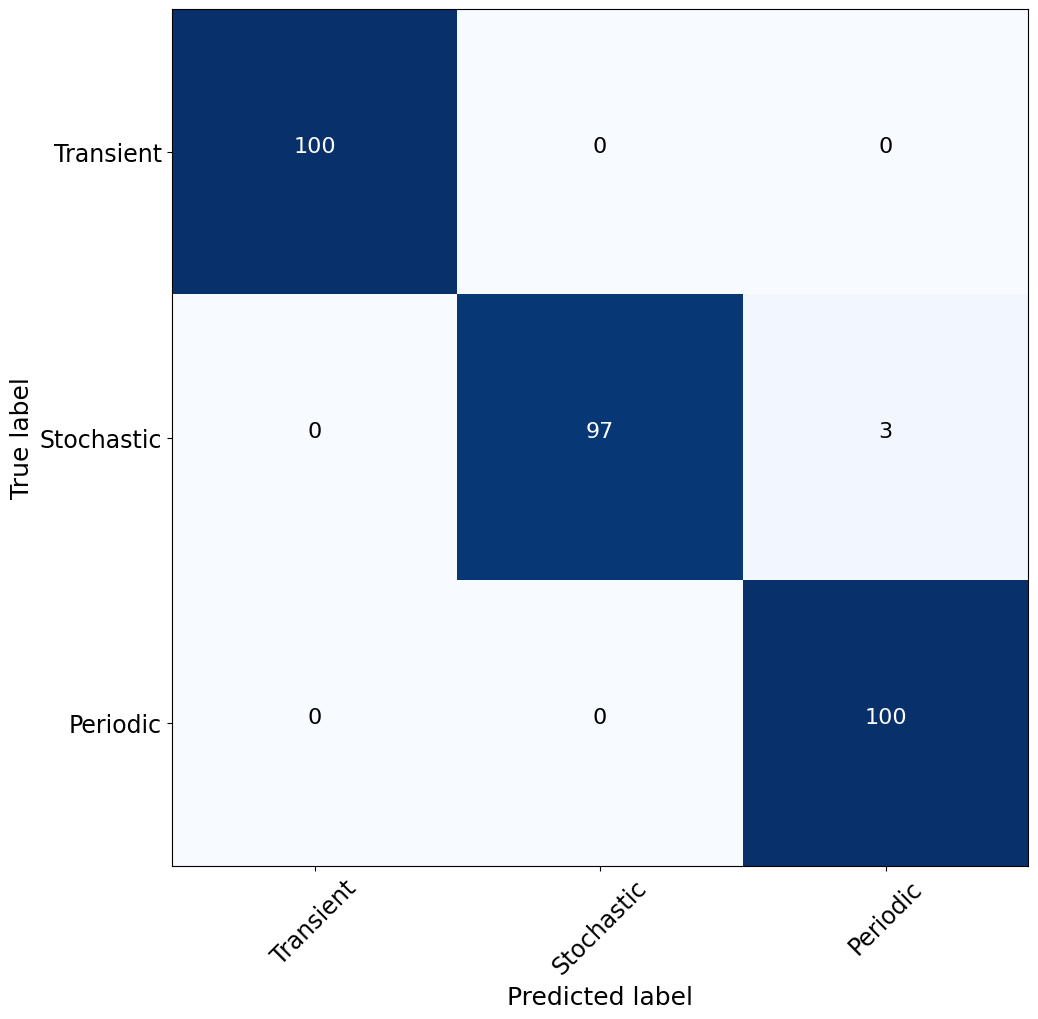

In [ ]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,'training_conf_matrix_hierarchical_level.pdf')

W1-W2 & 0.101
positive_fraction_1 & 0.055
sgscore1 & 0.051
positive_fraction_2 & 0.048
SPM_tau_rise_1 & 0.037
g-W3 & 0.033
W2-W3 & 0.032
LinearTrend_2 & 0.032
SPM_chi_1 & 0.030
g-W2 & 0.027
SPM_beta_1 & 0.027
n_non_det_after_fid_2 & 0.025
SPM_A_2 & 0.023
SPM_chi_2 & 0.022
SPM_A_1 & 0.018
SPM_tau_fall_1 & 0.017
SPM_tau_rise_2 & 0.016
ExcessVar_2 & 0.015
ExcessVar_1 & 0.015
Rcs_2 & 0.015
r-W2 & 0.015
r-W3 & 0.013
Meanvariance_2 & 0.012
LinearTrend_1 & 0.011
Meanvariance_1 & 0.010
MHPS_low_2 & 0.010
SPM_beta_2 & 0.009
GP_DRW_sigma_2 & 0.009
SF_ML_amplitude_2 & 0.009
Pvar_2 & 0.008


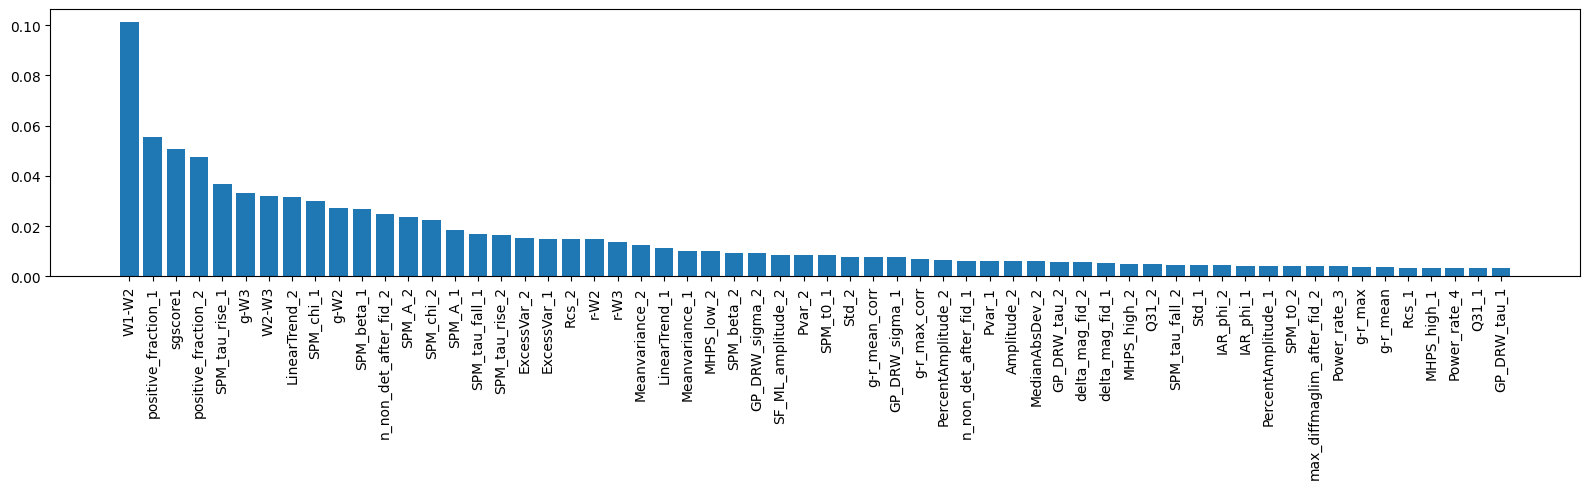

In [ ]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, 'final_BHRF_model/feature_ranking_hierarchical_level.pdf')

In [ ]:
#Try gradient boosting
#! pip install xgboost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


xgb_clas = XGBClassifier()
y_train_hierarchical1 = y_train_hierarchical.replace(['Periodic', 'Stochastic', 'Transient'], [0, 1, 2])

xgb_clas.fit(X_train_hierarchical, y_train_hierarchical1)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
y_true, y_pred = y_test_hierarchical.replace(['Periodic', 'Stochastic', 'Transient'], [0, 1, 2]), xgb_clas.predict(X_test_hierarchical)
print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))


Accuracy: 0.995668016194332
Balanced accuracy: 0.9937421211787812


In [ ]:
#CatBoost

! pip install catboost
from catboost import CatBoostClassifier

cb_clas = CatBoostClassifier()


y_train_hierarchical1 = y_train_hierarchical.replace(['Periodic', 'Stochastic', 'Transient'], [0, 1, 2])

cb_clas.fit(X_train_hierarchical, y_train_hierarchical1)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.5 MB/s eta 0:00:00
Learning rate set to 0.100013
0:	learn: 0.9280834	total: 421ms	remaining: 7m
1:	learn: 0.7987091	total: 738ms	remaining: 6m 8s
2:	learn: 0.6972884	total: 1.08s	remaining: 5m 57s
3:	learn: 0.6138331	total: 1.44s	remaining: 5m 58s
4:	learn: 0.5467866	total: 1.75s	remaining: 5m 47s
5:	learn: 0.4897133	total: 2s	remaining: 5m 32s
6:	learn: 0.4406588	total: 2.31s	remaining: 5m 28s
7:	learn: 0.3985311	total: 2.59s	remaining: 5m 20s
8:	learn: 0.3613503	total: 2.94s	remaining: 5m 24s
9:	learn: 0.3303366	total: 3.13s	remaining: 5m 9s
10:	learn: 0.3023703	total: 3.28s	remaining: 4m 55s
11:	learn: 0.2779954	total: 3.44s	remaining: 4m 43s
12:	learn: 0.2548423	total: 3.62s	remaining: 4m 35s
13:	learn: 0.2346614	total: 3.81s	remaining: 4m 28s
14:	learn: 0.2156365	total: 4.01s	remaining: 4m 23s
15:	learn: 0.1993529	total: 4.19s	remaining: 4m 17s
16:	learn: 0.1851388	total: 4.35s	remaining: 4m 11s
17:	learn: 0.1715054	tota

In [ ]:
y_true, y_pred = y_test_hierarchical.replace(['Periodic', 'Stochastic', 'Transient'], [0, 1, 2]), cb_clas.predict(X_test_hierarchical)
print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

Accuracy: 0.9944939271255061
Balanced accuracy: 0.9907386820514933


In [ ]:
#LightGBM

! pip install lightgbm

from lightgbm import LGBMClassifier


lgbm_clas = LGBMClassifier()

y_train_hierarchical1 = y_train_hierarchical.replace(['Periodic', 'Stochastic', 'Transient'], [0, 1, 2])

lgbm_clas.fit(X_train_hierarchical, y_train_hierarchical1)

LGBMClassifier()

In [ ]:
y_true, y_pred = y_test_hierarchical.replace(['Periodic', 'Stochastic', 'Transient'], [0, 1, 2]), lgbm_clas.predict(X_test_hierarchical)
print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))


Accuracy: 0.995668016194332
Balanced accuracy: 0.9909791951404436


All boosting methods have better accuracy than RF. XGBoost abd LightGBM have similar accuracy.